In [1]:
from google.colab import drive
import os

drive.mount('/content/drive')
work_pth = '/content/drive/MyDrive/Colab Notebooks/FinalProject'
os.chdir(work_pth)

Mounted at /content/drive


In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from transformers import DistilBertTokenizerFast
import torch
from torch.utils.data import DataLoader
from collections import Counter
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import torch.nn.functional as F

## Data Preprocessing

In [12]:
def clean_text(text):
    if not isinstance(text, str):
        return ""
    return text.replace('\n', ' ').replace('\r', ' ').strip()

In [13]:
# Data Loading
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv('cv_with_labels_shuffled.csv')
# df = pd.read_csv('cv_with_labels_shuffled_prompt2.csv')

df['CV'] = df['CV'].fillna('').astype(str).apply(clean_text)


In [14]:
import matplotlib.pyplot as plt
from transformers import DistilBertTokenizerFast


### DistillBERT Tokenized

In [8]:
# # Visualization to decide max_length (no need to run again)
# tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

# texts = df["CV"].tolist()
# encoded = tokenizer(texts, truncation=False, add_special_tokens=True)
# token_lengths = [len(x) for x in encoded["input_ids"]]

# token_series = pd.Series(token_lengths)
# print(token_series.describe(percentiles=[0.5, 0.9, 0.95, 0.99]))

# plt.hist(token_lengths, bins=50, color='skyblue')
# plt.axvline(512, color='red', linestyle='--', label='Transformer limit (512)')
# plt.xlabel("Token Length")
# plt.ylabel("Number of CVs")
# plt.title("Distribution of Token Lengths")
# plt.legend()
# plt.show()

In [9]:
# # Data Splitting

# texts = df['CV'].tolist()
# labels = df['rewritten_y'].tolist()

# train_texts, temp_texts, train_labels, temp_labels = train_test_split(
#     texts, labels, test_size=0.3, stratify=labels, random_state=42
# )


# val_texts, test_texts, val_labels, test_labels = train_test_split(
#     temp_texts, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42
# )

# # Tokenizer
# tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

# train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)
# val_encodings   = tokenizer(val_texts, truncation=True, padding=True, max_length=512)
# test_encodings  = tokenizer(test_texts, truncation=True, padding=True, max_length=512)

In [10]:
# Create Dataset
import torch

class CV_Dataset(torch.utils.data.Dataset):
    """
    Custom Dataset for BERT tokenized CV texts with binary classification labels.
    """
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        # Build input dictionary with tokenized input
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        # Add label as tensor (long for classification)
        item['labels'] = torch.tensor(self.labels[idx]).long()
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = CV_Dataset(train_encodings, train_labels)
val_dataset = CV_Dataset(val_encodings, val_labels)
test_dataset = CV_Dataset(test_encodings, test_labels)

In [ ]:
# Create DataLoader
from torch.utils.data import DataLoader
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Modeling

### Baseline Model

In [ ]:
from collections import Counter


counter = Counter(train_labels)
majority_class = counter.most_common(1)[0][0]
print(f"Majority class: {majority_class}")
majority_preds = [majority_class] * len(test_labels)

from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

acc = accuracy_score(test_labels, majority_preds)
f1 = f1_score(test_labels, majority_preds)
try:
    auc = roc_auc_score(test_labels, majority_preds)
except:
    auc = float('nan')

print(f"Majority Rule Baseline:\nAccuracy: {acc:.4f}, F1: {f1:.4f}, AUC: {auc}")


Majority class: 1
Majority Rule Baseline:
Accuracy: 0.4996, F1: 0.6663, AUC: 0.5


### HelperFunction

In [ ]:
from sklearn.metrics import accuracy_score
import numpy as np

def set_seed(seed=42):
    """
    Set random seed for reproducibility across different libraries.

    Args:
        seed (int): Random seed value
    """
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(42)

def train_model(model, loss_func, num_epochs, optimizer, train_loader, val_loader):
    train_loss_log = []
    val_loss_log = []
    train_acc_log = []
    val_acc_log = []

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(1, num_epochs + 1):
        model.train()
        total_loss = 0
        total_samples = 0
        all_preds = []
        all_labels = []

        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            logits = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = loss_func(logits, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * input_ids.size(0)
            total_samples += input_ids.size(0)

            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.detach().cpu().numpy())
            all_labels.extend(labels.detach().cpu().numpy())

        avg_train_loss = total_loss / total_samples
        train_acc = accuracy_score(all_labels, all_preds)

        train_loss_log.append(avg_train_loss)
        train_acc_log.append(train_acc)

        val_loss, val_acc = evaluate_model(model, val_loader, loss_func)
        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)

        print(f"Epoch {epoch}: Train Loss = {avg_train_loss:.4f}, Train Acc = {train_acc:.4f}, "
              f"Val Loss = {val_loss:.4f}, Val Acc = {val_acc:.4f}")

    return train_loss_log, val_loss_log, train_acc_log, val_acc_log


def evaluate_model(model, loader, loss_func):
    model.eval()
    total_loss = 0
    total_samples = 0
    all_preds = []
    all_labels = []

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            logits = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = loss_func(logits, labels)

            total_loss += loss.item() * input_ids.size(0)
            total_samples += input_ids.size(0)

            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.detach().cpu().numpy())
            all_labels.extend(labels.detach().cpu().numpy())

    avg_loss = total_loss / total_samples
    acc = accuracy_score(all_labels, all_preds)

    return avg_loss, acc



In [ ]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import torch.nn.functional as F

def evaluate_on_test(model, test_loader):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    all_preds = []
    all_probs = []
    all_labels = []
    total_loss = 0
    total_samples = 0
    loss_fn = nn.CrossEntropyLoss()

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            logits = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = loss_fn(logits, labels)

            probs = F.softmax(logits, dim=1)
            preds = torch.argmax(probs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs[:, 1].detach().cpu().numpy())  # 取 positive class 概率
            all_labels.extend(labels.cpu().numpy())

            total_loss += loss.item() * input_ids.size(0)
            total_samples += input_ids.size(0)

    avg_loss = total_loss / total_samples
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    auc = roc_auc_score(all_labels, all_probs)

    print(f"\nTest Loss: {avg_loss:.4f}")
    print(f"Accuracy : {acc:.4f}")
    print(f"F1 Score : {f1:.4f}")
    print(f"AUC      : {auc:.4f}")
    print(f"Label Distribution (0 = Human, 1 = AI): {np.bincount(all_labels)}")

    return {
        'loss': avg_loss,
        'accuracy': acc,
        'f1': f1,
        'auc': auc
    }


In [29]:
import matplotlib.pyplot as plt

def plot_metrics_curves(train_losses, val_losses, train_accs, val_accs):
    epochs = range(1, len(train_losses) + 1)

    fig, ax1 = plt.subplots(figsize=(9, 5))

    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color='tab:red')
    ax1.plot(epochs, train_losses, 'r-', label='Train Loss')
    ax1.plot(epochs, val_losses, 'r--', label='Val Loss')
    ax1.tick_params(axis='y', labelcolor='tab:red')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Accuracy', color='tab:blue')
    ax2.plot(epochs, train_accs, 'b-', label='Train Acc')
    ax2.plot(epochs, val_accs, 'b--', label='Val Acc')
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper center')

    plt.title('Loss and Accuracy Curves')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


### Model - DistilBERT (last 2 layers trainable) + MLP


In [ ]:
# def print_trainable_parameters(model):
#     total = sum(p.numel() for p in model.parameters())
#     trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
#     print(f"\nTrainable params: {trainable} / {total} "
#           f"({100 * trainable / total:.2f}%)\n")

#     print("Layers being tuned:")
#     for name, param in model.named_parameters():
#         if param.requires_grad:
#             print(f" - {name}")

In [ ]:
import torch
import torch.nn as nn
# from transformers import DistilBertModel

# class DistilBERT_MLP(nn.Module):
#     def __init__(self, layer_dims=[768, 256, 64, 2], activations=['ReLU', 'Tanh'], freeze_layers=True):
#         super().__init__()
#         self.bert = DistilBertModel.from_pretrained('distilbert-base-uncased')

#         if freeze_layers:
#             for name, param in self.bert.named_parameters():
#                 if "transformer.layer.4" not in name and "transformer.layer.5" not in name:
#                     param.requires_grad = False

#         layers = []
#         for i in range(len(layer_dims) - 2):
#             layers.append(nn.Linear(layer_dims[i], layer_dims[i+1]))
#             act_cls = getattr(nn, activations[i])
#             layers.append(act_cls())
#             layers.append(nn.Dropout(0.2))
#         layers.append(nn.Linear(layer_dims[-2], layer_dims[-1]))
#         self.classifier = nn.Sequential(*layers)

#     def forward(self, input_ids, attention_mask):
#         outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
#         cls_output = outputs.last_hidden_state[:, 0]
#         logits = self.classifier(cls_output)
#         return logits


In [ ]:
# model_1 = DistilBERT_MLP(
#     layer_dims=[768, 512, 256, 2],
#     activations=['GELU', 'ReLU'],
#     freeze_layers=True
# )

# optimizer = torch.optim.AdamW(model_1.parameters(), lr=2e-5)
# loss_func = nn.CrossEntropyLoss()

# train_loss_log, val_loss_log, train_acc_log, val_acc_log = train_model(
#     model_1, loss_func, num_epochs=3, optimizer=optimizer,
#     train_loader=train_loader, val_loader=val_loader
# )
# plot_metrics_curves(train_loss_log, val_loss_log, train_acc_log, val_acc_log)
# print_trainable_parameters(model_1)

In [ ]:
# evaluate_on_test(model_1, test_loader)

In [ ]:
# !pip install shap

In [ ]:
# import shap
# import torch
# import numpy as np
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model_1.to(device)
# def predict_proba(texts):
#     model_1.eval()
#     outputs = []

#     for text in texts:
#         inputs = tokenizer(text, return_tensors="pt", truncation=True, padding='max_length', max_length=512).to(device)

#         with torch.no_grad():
#             logits = model_1(**inputs)
#             probs = torch.softmax(logits, dim=1).cpu().numpy()

#         outputs.append(probs[0])

#     return np.array(outputs)  # shape: [n_samples, 2]


In [ ]:
# explainer = shap.Explainer(predict_proba, tokenizer)

In [ ]:
# sample_text = df[df['rewritten_y'] == 1]['CV'].dropna().iloc[0]
# shap_values = explainer([sample_text])

# shap.plots.text(shap_values[0])

In [ ]:
# import numpy as np
# import pandas as pd
# from collections import defaultdict
# import matplotlib.pyplot as plt
# from wordcloud import WordCloud

# # 1. 用模型生成预测标签（用 predict_proba）
# texts = df['CV'].dropna().tolist()
# probs = predict_proba(texts)  # shape: (n_samples, 2)

# df_valid = df[df['CV'].notna()].copy()
# df_valid['y_pred'] = (probs[:, 1] > 0.5).astype(int)

# # 2. 各取 50 篇样本
# ai_texts = df_valid[df_valid['y_pred'] == 1]['CV'].tolist()[:100]
# human_texts = df_valid[df_valid['y_pred'] == 0]['CV'].tolist()[:100]

# # 3. SHAP explainer（用 text + tokenizer 形式）
# ai_shap = explainer(ai_texts)
# human_shap = explainer(human_texts)

# # 4. 函数：提取 SHAP token 权重并过滤特殊符号
# def get_token_contributions(shap_values):
#     word_scores = defaultdict(float)
#     token_strs = shap_values.data
#     shap_vals = [v[:, 1] for v in shap_values.values]  # output 1 的 SHAP 值

#     for tokens, vals in zip(token_strs, shap_vals):
#         for tok, val in zip(tokens, vals):
#             if tok not in ['[CLS]', '[SEP]', '[PAD]', '', '▁']:
#                 word_scores[tok] += val

#     return {k: v for k, v in word_scores.items() if not np.isnan(v)}

# # 5. 分别获取 AI 和 Human 的词权重字典
# ai_scores = get_token_contributions(ai_shap)
# human_scores = get_token_contributions(human_shap)

# # 6. 绘图：双词云对比
# fig, axs = plt.subplots(1, 2, figsize=(24, 10))

# wc_ai = WordCloud(width=800, height=600, background_color='white') \
#     .generate_from_frequencies(ai_scores)
# wc_human = WordCloud(width=800, height=600, background_color='white') \
#     .generate_from_frequencies(human_scores)

# axs[0].imshow(wc_ai, interpolation='bilinear')
# axs[0].set_title("Tokens Pushing Toward AI Rewriting", fontsize=18)
# axs[0].axis("off")

# axs[1].imshow(wc_human, interpolation='bilinear')
# axs[1].set_title("Tokens Pushing Toward Human Writing", fontsize=18)
# axs[1].axis("off")

# plt.tight_layout()
# plt.show()



##path A: GloVe + AvgPool + MLP ##

In [ ]:
def load_glove_embeddings(glove_path, embedding_dim=100):
    embeddings_index = {}
    with open(glove_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            if len(vector) == embedding_dim:
                embeddings_index[word] = vector
    return embeddings_index

glove_path = '/content/drive/MyDrive/Colab Notebooks/FinalProject/glove.6B.100d.txt'
embedding_dim = 100
glove_index = load_glove_embeddings(glove_path, embedding_dim)

In [ ]:
import re

def tokenize(text):
    return re.findall(r"\b\w+\b", text.lower())

def text_to_avg_glove(texts, glove_index, embedding_dim=100):
    embeddings = []
    for text in texts:
        tokens = tokenize(text)
        vectors = [glove_index[token] for token in tokens if token in glove_index]
        if vectors:
            avg_vector = np.mean(vectors, axis=0)
        else:
            avg_vector = np.zeros(embedding_dim)
        embeddings.append(avg_vector)
    return np.array(embeddings)


In [ ]:
X_train = text_to_avg_glove(train_texts, glove_index, embedding_dim)
X_val   = text_to_avg_glove(val_texts, glove_index, embedding_dim)
X_test  = text_to_avg_glove(test_texts, glove_index, embedding_dim)

train_dataset = torch.utils.data.TensorDataset(torch.tensor(X_train).float(), torch.tensor(train_labels))
val_dataset   = torch.utils.data.TensorDataset(torch.tensor(X_val).float(), torch.tensor(val_labels))
test_dataset  = torch.utils.data.TensorDataset(torch.tensor(X_test).float(), torch.tensor(test_labels))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = torch.utils.data.DataLoader(val_dataset, batch_size=32)
test_loader  = torch.utils.data.DataLoader(test_dataset, batch_size=32)


In [ ]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim=100, layer_dims=[64, 32, 2], activations=['ReLU', 'ReLU']):
        super().__init__()
        layers = []
        dims = [input_dim] + layer_dims

        for i in range(len(dims) - 2):
            layers.append(nn.Linear(dims[i], dims[i+1]))
            act_cls = getattr(nn, activations[i])
            layers.append(act_cls())
            layers.append(nn.Dropout(0.2))
        layers.append(nn.Linear(dims[-2], dims[-1]))
        self.classifier = nn.Sequential(*layers)

    def forward(self, x):
        return self.classifier(x)


In [ ]:
def train_model_glove(model, loss_func, num_epochs, optimizer, train_loader, val_loader):
    train_loss_log = []
    val_loss_log = []
    train_acc_log = []
    val_acc_log = []

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(1, num_epochs + 1):
        model.train()
        total_loss = 0
        total_samples = 0
        all_preds = []
        all_labels = []

        for batch in train_loader:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)

            logits = model(inputs)
            loss = loss_func(logits, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * inputs.size(0)
            total_samples += inputs.size(0)

            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.detach().cpu().numpy())
            all_labels.extend(labels.detach().cpu().numpy())

        avg_train_loss = total_loss / total_samples
        train_acc = accuracy_score(all_labels, all_preds)

        val_loss, val_acc = evaluate_model_glove(model, val_loader, loss_func)

        train_loss_log.append(avg_train_loss)
        val_loss_log.append(val_loss)
        train_acc_log.append(train_acc)
        val_acc_log.append(val_acc)

        print(f"Epoch {epoch}: Train Loss = {avg_train_loss:.4f}, Train Acc = {train_acc:.4f}, "
              f"Val Loss = {val_loss:.4f}, Val Acc = {val_acc:.4f}")

    return train_loss_log, val_loss_log, train_acc_log, val_acc_log


In [ ]:
def evaluate_model_glove(model, loader, loss_func):
    model.eval()
    total_loss = 0
    total_samples = 0
    all_preds = []
    all_labels = []

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    with torch.no_grad():
        for batch in loader:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)

            logits = model(inputs)
            loss = loss_func(logits, labels)

            total_loss += loss.item() * inputs.size(0)
            total_samples += inputs.size(0)

            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / total_samples
    acc = accuracy_score(all_labels, all_preds)
    return avg_loss, acc


In [ ]:
def evaluate_on_test_glove(model, test_loader):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    all_preds = []
    all_probs = []
    all_labels = []
    total_loss = 0
    total_samples = 0
    loss_fn = nn.CrossEntropyLoss()

    with torch.no_grad():
        for batch in test_loader:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)

            logits = model(inputs)
            loss = loss_fn(logits, labels)

            probs = F.softmax(logits, dim=1)
            preds = torch.argmax(probs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs[:, 1].detach().cpu().numpy())  # 取 positive class 概率
            all_labels.extend(labels.cpu().numpy())

            total_loss += loss.item() * inputs.size(0)
            total_samples += inputs.size(0)

    avg_loss = total_loss / total_samples
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    auc = roc_auc_score(all_labels, all_probs)

    print(f"\nTest Loss: {avg_loss:.4f}")
    print(f"Accuracy : {acc:.4f}")
    print(f"F1 Score : {f1:.4f}")
    print(f"AUC      : {auc:.4f}")
    print(f"Label Distribution (0 = Human, 1 = AI): {np.bincount(all_labels)}")

    return {
        'loss': avg_loss,
        'accuracy': acc,
        'f1': f1,
        'auc': auc
    }


Epoch 1: Train Loss = 0.6819, Train Acc = 0.6217, Val Loss = 0.6528, Val Acc = 0.8545
Epoch 2: Train Loss = 0.5697, Train Acc = 0.8344, Val Loss = 0.4297, Val Acc = 0.8876
Epoch 3: Train Loss = 0.3638, Train Acc = 0.8769, Val Loss = 0.2801, Val Acc = 0.9083
Epoch 4: Train Loss = 0.2818, Train Acc = 0.9003, Val Loss = 0.2334, Val Acc = 0.9248
Epoch 5: Train Loss = 0.2541, Train Acc = 0.9051, Val Loss = 0.2118, Val Acc = 0.9174
Epoch 6: Train Loss = 0.2303, Train Acc = 0.9152, Val Loss = 0.2017, Val Acc = 0.9281
Epoch 7: Train Loss = 0.2188, Train Acc = 0.9191, Val Loss = 0.1816, Val Acc = 0.9331
Epoch 8: Train Loss = 0.2082, Train Acc = 0.9246, Val Loss = 0.1729, Val Acc = 0.9322
Epoch 9: Train Loss = 0.1941, Train Acc = 0.9302, Val Loss = 0.1619, Val Acc = 0.9388
Epoch 10: Train Loss = 0.1867, Train Acc = 0.9322, Val Loss = 0.1626, Val Acc = 0.9322


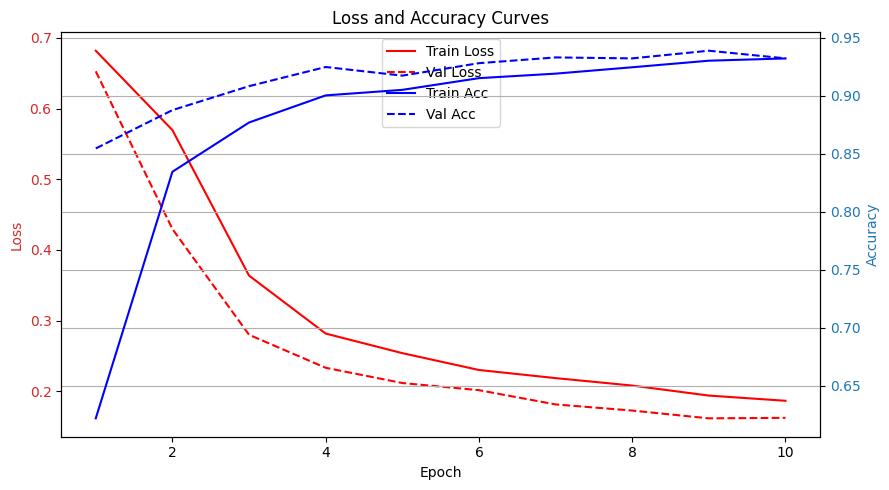


Test Loss: 0.1788
Accuracy : 0.9356
F1 Score : 0.9375
AUC      : 0.9825
Label Distribution (0 = Human, 1 = AI): [606 605]


{'loss': 0.1788225147125644,
 'accuracy': 0.935590421139554,
 'f1': 0.9375,
 'auc': np.float64(0.9825273436434554)}

In [ ]:
model_glove = MLPClassifier(input_dim=100)
optimizer = torch.optim.AdamW(model_glove.parameters(), lr=2e-4)
loss_func = nn.CrossEntropyLoss()

train_loss_log, val_loss_log, train_acc_log, val_acc_log = train_model_glove(
    model_glove, loss_func, num_epochs=10, optimizer=optimizer,
    train_loader=train_loader, val_loader=val_loader
)

plot_metrics_curves(train_loss_log, val_loss_log, train_acc_log, val_acc_log)
evaluate_on_test_glove(model_glove, test_loader)


In [ ]:
df2 = pd.read_csv('cv_with_labels_shuffled_prompt2.csv')
df2['CV'] = df2['CV'].fillna('').astype(str).apply(clean_text)

texts2 = df2['CV'].tolist()
labels2 = df2['rewritten_y'].tolist()


In [ ]:
X_test2 = text_to_avg_glove(texts2, glove_index, embedding_dim=100)
test_dataset2 = torch.utils.data.TensorDataset(torch.tensor(X_test2).float(), torch.tensor(labels2))
test_loader2 = torch.utils.data.DataLoader(test_dataset2, batch_size=32)
evaluate_on_test_glove(model_glove, test_loader2)



Test Loss: 0.3605
Accuracy : 0.8596
F1 Score : 0.9245
AUC      : nan
Label Distribution (0 = Human, 1 = AI): [  0 413]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


{'loss': 0.36053736143481646,
 'accuracy': 0.8595641646489104,
 'f1': 0.9244791666666666,
 'auc': nan}

## Mix Prompt ##

In [15]:
# Mixing dataset
df_orig = pd.read_csv('cv_with_labels_shuffled.csv')
df_all = pd.read_csv('cv_with_labels_shuffled_prompt2_9.csv')
df_all.rename(columns={'Rewritten': 'CV'}, inplace=True)
df_orig['CV'] = df_orig['CV'].fillna('').astype(str).apply(clean_text)
df_all['CV'] = df_all['CV'].fillna('').astype(str).apply(clean_text)

# Sampling
df_p1 = df_orig[df_orig['rewritten_y'] == 1].sample(n=658, random_state=42) # prompt1
df_p2 = df_all[df_all['Prompt'] == 2] # Prompt2
df_p3_9 = df_all[df_all['Prompt'].isin([3,4,5,6,7,8,9])] # Prompt3
df_y1 = pd.concat([df_p1, df_p2, df_p3_9], ignore_index=True)
df_y0 = df_orig[df_orig['rewritten_y'] == 0].sample(n=len(df_y1), random_state=42)


df_mixed = pd.concat([df_y1, df_y0], ignore_index=True).sample(frac=1, random_state=42).reset_index(drop=True)

In [16]:
class CV_Dataset(torch.utils.data.Dataset):
    """
    Custom Dataset for BERT tokenized CV texts with binary classification labels.
    """
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        # Build input dictionary with tokenized input
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        # Add label as tensor (long for classification)
        item['labels'] = torch.tensor(self.labels[idx]).long()
        return item

    def __len__(self):
        return len(self.labels)

In [18]:
# Data Preprocessing
texts = df_mixed['CV'].tolist()
labels = df_mixed['rewritten_y'].tolist()

train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    texts, labels, test_size=0.3, stratify=labels, random_state=42
)


val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42
)

# Tokenizer
# tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

# train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)
# val_encodings   = tokenizer(val_texts, truncation=True, padding=True, max_length=512)
# test_encodings  = tokenizer(test_texts, truncation=True, padding=True, max_length=512)

# train_dataset = CV_Dataset(train_encodings, train_labels)
# val_dataset = CV_Dataset(val_encodings, val_labels)
# test_dataset = CV_Dataset(test_encodings, test_labels)

# train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

## New Path A##

In [19]:
def load_glove_embeddings(glove_path, embedding_dim=100):
    embeddings_index = {}
    with open(glove_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            if len(vector) == embedding_dim:
                embeddings_index[word] = vector
    return embeddings_index

glove_path = '/content/drive/MyDrive/Colab Notebooks/FinalProject/glove.6B.100d.txt'
embedding_dim = 100
glove_index = load_glove_embeddings(glove_path, embedding_dim)

In [20]:
import re

def tokenize(text):
    return re.findall(r"\b\w+\b", text.lower())

def text_to_avg_glove(texts, glove_index, embedding_dim=100):
    embeddings = []
    for text in texts:
        tokens = tokenize(text)
        vectors = [glove_index[token] for token in tokens if token in glove_index]
        if vectors:
            avg_vector = np.mean(vectors, axis=0)
        else:
            avg_vector = np.zeros(embedding_dim)
        embeddings.append(avg_vector)
    return np.array(embeddings)


In [21]:
X_train = text_to_avg_glove(train_texts, glove_index, embedding_dim)
X_val   = text_to_avg_glove(val_texts, glove_index, embedding_dim)
X_test  = text_to_avg_glove(test_texts, glove_index, embedding_dim)

train_dataset = torch.utils.data.TensorDataset(torch.tensor(X_train).float(), torch.tensor(train_labels))
val_dataset   = torch.utils.data.TensorDataset(torch.tensor(X_val).float(), torch.tensor(val_labels))
test_dataset  = torch.utils.data.TensorDataset(torch.tensor(X_test).float(), torch.tensor(test_labels))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = torch.utils.data.DataLoader(val_dataset, batch_size=32)
test_loader  = torch.utils.data.DataLoader(test_dataset, batch_size=32)


In [24]:
import torch
import torch.nn as nn

class MLPClassifier(nn.Module):
    def __init__(self, input_dim=100, layer_dims=[64, 32, 2], activations=['ReLU', 'ReLU']):
        super().__init__()
        layers = []
        dims = [input_dim] + layer_dims

        for i in range(len(dims) - 2):
            layers.append(nn.Linear(dims[i], dims[i+1]))
            act_cls = getattr(nn, activations[i])
            layers.append(act_cls())
            layers.append(nn.Dropout(0.2))
        layers.append(nn.Linear(dims[-2], dims[-1]))
        self.classifier = nn.Sequential(*layers)

    def forward(self, x):
        return self.classifier(x)


In [25]:
def train_model_glove(model, loss_func, num_epochs, optimizer, train_loader, val_loader):
    train_loss_log = []
    val_loss_log = []
    train_acc_log = []
    val_acc_log = []

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(1, num_epochs + 1):
        model.train()
        total_loss = 0
        total_samples = 0
        all_preds = []
        all_labels = []

        for batch in train_loader:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)

            logits = model(inputs)
            loss = loss_func(logits, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * inputs.size(0)
            total_samples += inputs.size(0)

            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.detach().cpu().numpy())
            all_labels.extend(labels.detach().cpu().numpy())

        avg_train_loss = total_loss / total_samples
        train_acc = accuracy_score(all_labels, all_preds)

        val_loss, val_acc = evaluate_model_glove(model, val_loader, loss_func)

        train_loss_log.append(avg_train_loss)
        val_loss_log.append(val_loss)
        train_acc_log.append(train_acc)
        val_acc_log.append(val_acc)

        print(f"Epoch {epoch}: Train Loss = {avg_train_loss:.4f}, Train Acc = {train_acc:.4f}, "
              f"Val Loss = {val_loss:.4f}, Val Acc = {val_acc:.4f}")

    return train_loss_log, val_loss_log, train_acc_log, val_acc_log


In [26]:
def evaluate_model_glove(model, loader, loss_func):
    model.eval()
    total_loss = 0
    total_samples = 0
    all_preds = []
    all_labels = []

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    with torch.no_grad():
        for batch in loader:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)

            logits = model(inputs)
            loss = loss_func(logits, labels)

            total_loss += loss.item() * inputs.size(0)
            total_samples += inputs.size(0)

            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / total_samples
    acc = accuracy_score(all_labels, all_preds)
    return avg_loss, acc


In [27]:
def evaluate_on_test_glove(model, test_loader):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    all_preds = []
    all_probs = []
    all_labels = []
    total_loss = 0
    total_samples = 0
    loss_fn = nn.CrossEntropyLoss()

    with torch.no_grad():
        for batch in test_loader:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)

            logits = model(inputs)
            loss = loss_fn(logits, labels)

            probs = F.softmax(logits, dim=1)
            preds = torch.argmax(probs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs[:, 1].detach().cpu().numpy())  # 取 positive class 概率
            all_labels.extend(labels.cpu().numpy())

            total_loss += loss.item() * inputs.size(0)
            total_samples += inputs.size(0)

    avg_loss = total_loss / total_samples
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    auc = roc_auc_score(all_labels, all_probs)

    print(f"\nTest Loss: {avg_loss:.4f}")
    print(f"Accuracy : {acc:.4f}")
    print(f"F1 Score : {f1:.4f}")
    print(f"AUC      : {auc:.4f}")
    print(f"Label Distribution (0 = Human, 1 = AI): {np.bincount(all_labels)}")

    return {
        'loss': avg_loss,
        'accuracy': acc,
        'f1': f1,
        'auc': auc
    }


In [30]:
import matplotlib.pyplot as plt

def plot_metrics_curves(train_losses, val_losses, train_accs, val_accs):
    epochs = range(1, len(train_losses) + 1)

    fig, ax1 = plt.subplots(figsize=(9, 5))

    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color='tab:red')
    ax1.plot(epochs, train_losses, 'r-', label='Train Loss')
    ax1.plot(epochs, val_losses, 'r--', label='Val Loss')
    ax1.tick_params(axis='y', labelcolor='tab:red')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Accuracy', color='tab:blue')
    ax2.plot(epochs, train_accs, 'b-', label='Train Acc')
    ax2.plot(epochs, val_accs, 'b--', label='Val Acc')
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper center')

    plt.title('Loss and Accuracy Curves')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


##Learning rate = 2e-4##

Epoch 1: Train Loss = 0.6831, Train Acc = 0.5907, Val Loss = 0.6621, Val Acc = 0.7387
Epoch 2: Train Loss = 0.6082, Train Acc = 0.7663, Val Loss = 0.5408, Val Acc = 0.7847
Epoch 3: Train Loss = 0.4737, Train Acc = 0.8170, Val Loss = 0.4318, Val Acc = 0.8252
Epoch 4: Train Loss = 0.3913, Train Acc = 0.8420, Val Loss = 0.3732, Val Acc = 0.8464
Epoch 5: Train Loss = 0.3493, Train Acc = 0.8645, Val Loss = 0.3453, Val Acc = 0.8583
Epoch 6: Train Loss = 0.3342, Train Acc = 0.8663, Val Loss = 0.3234, Val Acc = 0.8730
Epoch 7: Train Loss = 0.3108, Train Acc = 0.8787, Val Loss = 0.3074, Val Acc = 0.8786
Epoch 8: Train Loss = 0.2977, Train Acc = 0.8848, Val Loss = 0.2930, Val Acc = 0.8786
Epoch 9: Train Loss = 0.2859, Train Acc = 0.8862, Val Loss = 0.2847, Val Acc = 0.8878
Epoch 10: Train Loss = 0.2778, Train Acc = 0.8872, Val Loss = 0.2772, Val Acc = 0.8813


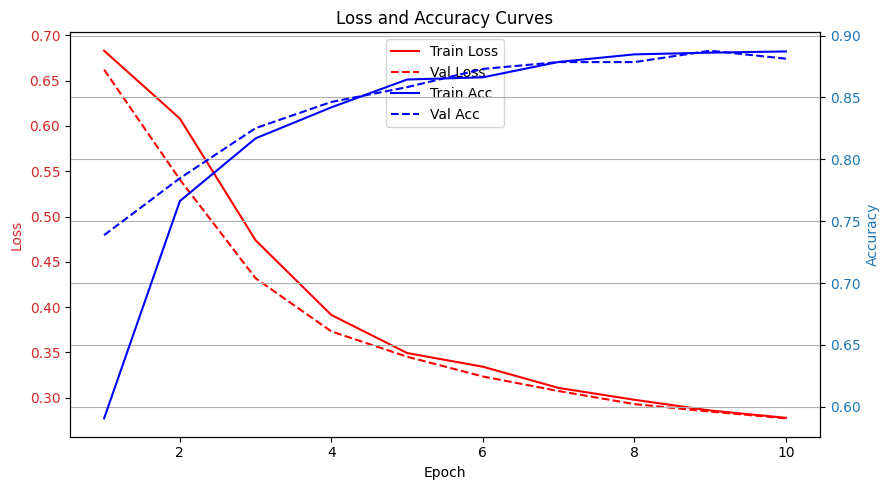


Test Loss: 0.2530
Accuracy : 0.8997
F1 Score : 0.8992
AUC      : 0.9629
Label Distribution (0 = Human, 1 = AI): [544 543]


{'loss': 0.25304300682799136,
 'accuracy': 0.8997240110395585,
 'f1': 0.8991674375578168,
 'auc': np.float64(0.9629035315783773)}

In [31]:
model_glove = MLPClassifier(input_dim=100)
optimizer = torch.optim.AdamW(model_glove.parameters(), lr=2e-4)
loss_func = nn.CrossEntropyLoss()

train_loss_log, val_loss_log, train_acc_log, val_acc_log = train_model_glove(
    model_glove, loss_func, num_epochs=10, optimizer=optimizer,
    train_loader=train_loader, val_loader=val_loader
)

plot_metrics_curves(train_loss_log, val_loss_log, train_acc_log, val_acc_log)
evaluate_on_test_glove(model_glove, test_loader)


##Learning rate = 2e-5##

Epoch 1: Train Loss = 0.6931, Train Acc = 0.5041, Val Loss = 0.6926, Val Acc = 0.4995
Epoch 2: Train Loss = 0.6912, Train Acc = 0.5114, Val Loss = 0.6906, Val Acc = 0.4995
Epoch 3: Train Loss = 0.6898, Train Acc = 0.5288, Val Loss = 0.6891, Val Acc = 0.4995
Epoch 4: Train Loss = 0.6889, Train Acc = 0.5337, Val Loss = 0.6877, Val Acc = 0.5014
Epoch 5: Train Loss = 0.6872, Train Acc = 0.5680, Val Loss = 0.6861, Val Acc = 0.5621
Epoch 6: Train Loss = 0.6852, Train Acc = 0.5854, Val Loss = 0.6841, Val Acc = 0.6661
Epoch 7: Train Loss = 0.6828, Train Acc = 0.6136, Val Loss = 0.6817, Val Acc = 0.6780
Epoch 8: Train Loss = 0.6799, Train Acc = 0.6339, Val Loss = 0.6787, Val Acc = 0.7093
Epoch 9: Train Loss = 0.6771, Train Acc = 0.6542, Val Loss = 0.6750, Val Acc = 0.7332
Epoch 10: Train Loss = 0.6720, Train Acc = 0.6769, Val Loss = 0.6705, Val Acc = 0.7323


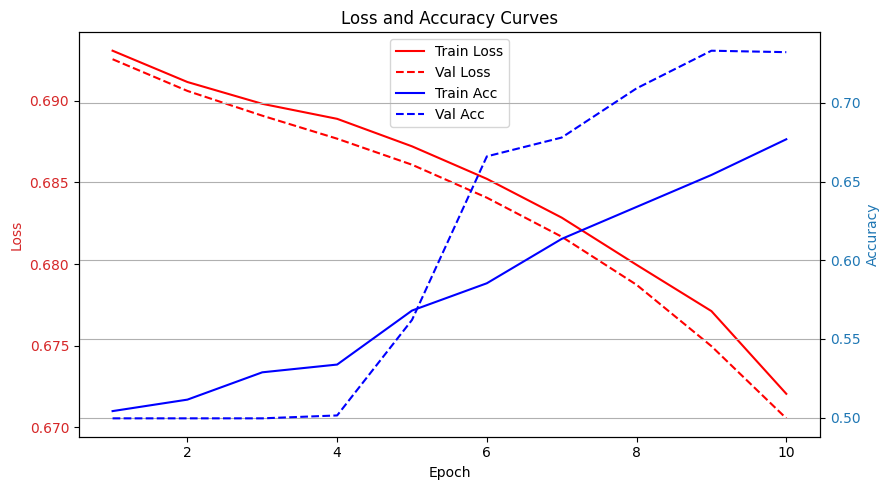


Test Loss: 0.6684
Accuracy : 0.7608
F1 Score : 0.7280
AUC      : 0.8622
Label Distribution (0 = Human, 1 = AI): [544 543]


{'loss': 0.6683541814339962,
 'accuracy': 0.7608095676172953,
 'f1': 0.7280334728033473,
 'auc': np.float64(0.8621831329216768)}

In [34]:
model_glove = MLPClassifier(input_dim=100)
optimizer = torch.optim.AdamW(model_glove.parameters(), lr=2e-5)
loss_func = nn.CrossEntropyLoss()

train_loss_log, val_loss_log, train_acc_log, val_acc_log = train_model_glove(
    model_glove, loss_func, num_epochs=10, optimizer=optimizer,
    train_loader=train_loader, val_loader=val_loader
)

plot_metrics_curves(train_loss_log, val_loss_log, train_acc_log, val_acc_log)
evaluate_on_test_glove(model_glove, test_loader)
